In [12]:
import os # Configure which GPU 
#import sys
import torch
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

no_preview = True

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.mimo.precoding import normalize_precoding_power, grid_of_beams_dft
from sionna.rt import visualize 
import math

In [14]:
# List of different TX antenna counts to analyze
num_tx_row_list = [1, 16, 64]

def calculate_total_pdBm(P_single_dBm, num_antennas):
    """
    Calculate the total transmit power in dBm given the power of a single antenna
    and the number of antennas in the array.
    """
    # Convert power from dBm to Watts
    P_single_W = 10 ** ((P_single_dBm - 30) / 10)
    
    # Total power assuming antennas transmit independently (no beamforming gain)
    P_total_W = P_single_W * num_antennas
    
    # Convert total power back to dBm
    P_total_dBm = 10 * np.log10(P_total_W) + 30
    
    return P_total_dBm

# Example usage: calculate effective TX power for 1, 16, and 64 antenna elements
TX_pwr = 10  # Transmit power per antenna in dBm
new_TX_pwr = {}
for num_ant in num_tx_row_list:
    new_TX_pwr[num_ant] = calculate_total_pdBm(TX_pwr, num_ant)

print(new_TX_pwr)  # Display the resulting total powers

def config_scene(num_rows, num_cols, pattern, bs_pwr, tx_pos):
    """
    Configure the simulation scene with the specified transmitter parameters.
    """
    # Load the predefined urban Munich scene
    scene = load_scene(sionna.rt.scene.munich)

    # Set scene-level parameters
    scene.bandwidth = 100e6  # 100 MHz bandwidth
    scene.frequency = 2.14e9  # Center frequency of 2.14 GHz
    scene.synthetic_array = True  # Enable synthetic array processing
    
    # Set the transmitter antenna array with specified dimensions and pattern
    scene.tx_array = PlanarArray(
        num_rows=num_rows,
        num_cols=num_cols,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern=pattern,
        polarization="V"
    )

    # Set the receiver antenna array (1x1 isotropic antenna)
    scene.rx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="iso",
        polarization="V"
    )
    
    # Transmitter's look-at direction (faces 100m ahead along the x-axis)
    base_look_at = [tx_pos[0] + 100, tx_pos[1], 0]

    # Debug prints for verification
    print(scene.tx_array.num_ant)
    print(bs_pwr)
    
    # Add the transmitter to the scene
    scene.add(Transmitter(
        name='tx0',
        position=tx_pos,
        look_at=base_look_at,
        power_dbm=bs_pwr
    ))

    return scene

def create_coverage_maps(num_rows, num_cols, tx_types, bs_pwr, tx_pos,
                         max_depth=5, diffraction=True, cm_cell_size=(5., 5.),
                         combining_vec=None, precoding_vec=None, num_samples=int(20e6)):
    """
    Generate coverage maps for different antenna radiation patterns.
    """
    coverage_maps = {}
    scene_maps = {}

    for tx_type in tx_types:
        print(tx_type)  # Log the current antenna pattern being simulated
        
        # Configure the scene for this antenna pattern
        scene = config_scene(num_rows, num_cols, tx_type, bs_pwr, tx_pos)
        scene_maps[tx_type] = scene
        
        # Generate and store the coverage map
        coverage_maps[tx_type] = scene.coverage_map(
            max_depth=max_depth,
            diffraction=diffraction,
            cm_cell_size=cm_cell_size,
            combining_vec=combining_vec,
            precoding_vec=precoding_vec,
            num_samples=num_samples
        )

    return coverage_maps, scene_maps

# Simulation parameters
TX_PWR = 10  # Power per TX antenna in dBm
TX_POS = [-50, 100, 105]  # Transmitter position in 3D space
tx_types = ["iso", "tr38901", "dipole"]  # Types of antenna radiation patterns

# Generate coverage maps for:
# - Single antenna (1x1 array)
cm1, sm1 = create_coverage_maps(1, 1, tx_types, TX_PWR, TX_POS)

# - 16-element array (4x4)
cm16, sm16 = create_coverage_maps(4, 4, tx_types, TX_PWR, TX_POS)

# - 64-element array (8x8)
cm64, sm64 = create_coverage_maps(8, 8, tx_types, TX_PWR, TX_POS)


{1: 10.0, 16: 22.04119982655925, 64: 28.06179973983887}
iso
1
10
tr38901
1
10
dipole
1
10
iso
16
10
tr38901
16
10
dipole
16
10
iso
64
10
tr38901
64
10
dipole
64
10


In [15]:
# Define coverage map dictionary for each TX config and antenna pattern
cm_maps = {
    "cm64_iso": cm64['iso'],       # 64-antenna array with isotropic pattern
    "cm16_iso": cm16['iso'],       # 16-antenna array with isotropic pattern
    "cm1_iso": cm1['iso'],         # Single antenna with isotropic pattern
    "cm64_tr": cm64['tr38901'],    # 64-antenna array with TR 38.901 pattern
    "cm16_tr": cm16['tr38901'],    # 16-antenna array with TR 38.901 pattern
    "cm1_tr": cm1['tr38901'],      # Single antenna with TR 38.901 pattern
    "cm64_di": cm64['dipole'],     # 64-antenna array with dipole pattern
    "cm16_di": cm16['dipole'],     # 16-antenna array with dipole pattern
    "cm1_di": cm1['dipole'],       # Single antenna with dipole pattern
}

# Store the corresponding scene objects for each configuration
scene_maps = {
    "cm64_iso": sm64['iso'],
    "cm16_iso": sm16['iso'],
    "cm1_iso": sm1['iso'],
    "cm64_tr": sm64['tr38901'],
    "cm16_tr": sm16['tr38901'],
    "cm1_tr": sm1['tr38901'],
    "cm64_di": sm64['dipole'],
    "cm16_di": sm16['dipole'],
    "cm1_di": sm1['dipole'],
}

# Extract SINR (Signal to Interference plus Noise Ratio) maps from each coverage map
sinr_maps = {
    "cm64_iso": cm64['iso'].sinr,
    "cm16_iso": cm16['iso'].sinr,
    "cm1_iso": cm1['iso'].sinr,
    "cm64_tr": cm64['tr38901'].sinr,
    "cm16_tr": cm16['tr38901'].sinr,
    "cm1_tr": cm1['tr38901'].sinr,
    "cm64_di": cm64['dipole'].sinr,
    "cm16_di": cm16['dipole'].sinr,
    "cm1_di": cm1['dipole'].sinr,
}

# Convert SINR to dB scale (10*log10)
coverage_maps_dB = {
    "cm64_iso": 10 * tf.math.log(cm64['iso'].sinr) / tf.math.log(10.0),
    "cm16_iso": 10 * tf.math.log(cm16['iso'].sinr) / tf.math.log(10.0),
    "cm1_iso": 10 * tf.math.log(cm1['iso'].sinr) / tf.math.log(10.0),
    "cm64_tr": 10 * tf.math.log(cm64['tr38901'].sinr) / tf.math.log(10.0),
    "cm16_tr": 10 * tf.math.log(cm16['tr38901'].sinr) / tf.math.log(10.0),
    "cm1_tr": 10 * tf.math.log(cm1['tr38901'].sinr) / tf.math.log(10.0),
    "cm64_di": 10 * tf.math.log(cm64['dipole'].sinr) / tf.math.log(10.0),
    "cm16_di": 10 * tf.math.log(cm16['dipole'].sinr) / tf.math.log(10.0),
    "cm1_di": 10 * tf.math.log(cm1['dipole'].sinr) / tf.math.log(10.0),
}

# Extract path gain (in linear scale) for all configurations
path_gain_maps = {
    "cm64_iso": cm64['iso'].path_gain,
    "cm16_iso": cm16['iso'].path_gain,
    "cm1_iso": cm1['iso'].path_gain,
    "cm64_tr": cm64['tr38901'].path_gain,
    "cm16_tr": cm16['tr38901'].path_gain,
    "cm1_tr": cm1['tr38901'].path_gain,
    "cm64_di": cm64['dipole'].path_gain,
    "cm16_di": cm16['dipole'].path_gain,
    "cm1_di": cm1['dipole'].path_gain,
}

# Extract RSS (Received Signal Strength) for all configurations
rss_maps = {
    "cm64_iso": cm64['iso'].rss,
    "cm16_iso": cm16['iso'].rss,
    "cm1_iso": cm1['iso'].rss,
    "cm64_tr": cm64['tr38901'].rss,
    "cm16_tr": cm16['tr38901'].rss,
    "cm1_tr": cm1['tr38901'].rss,
    "cm64_di": cm64['dipole'].rss,
    "cm16_di": cm16['dipole'].rss,
    "cm1_di": cm1['dipole'].rss,
}


1 TX antenna (iso): Max SINR = 25.803112983703613
16 TX antennas (iso): Max SINR = 34.42864418029785
64 TX antennas (iso): Max SINR = 40.14979362487793


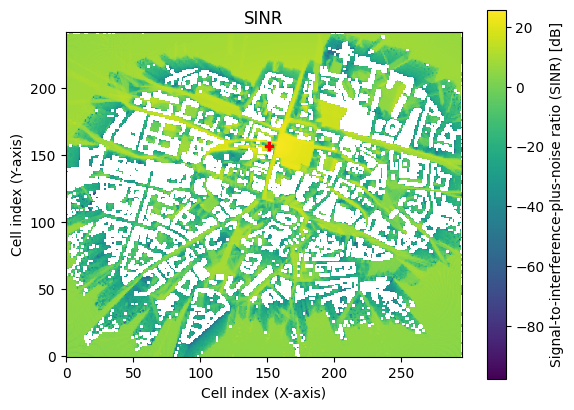

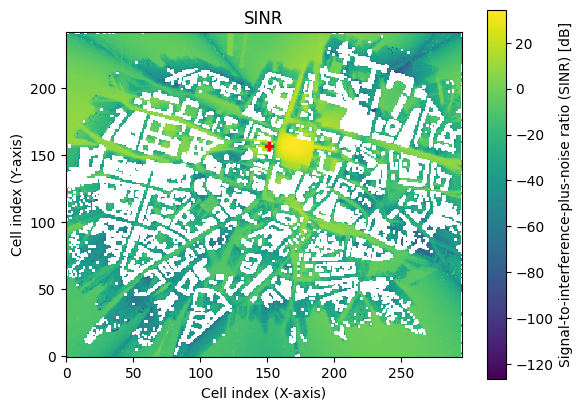

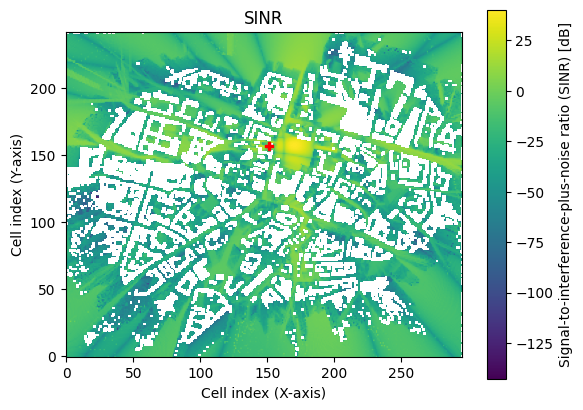

In [16]:
# --- Comparing SINR for Isotropic Antenna Configurations ---

# Visualize SINR map for single TX antenna (1x1) with isotropic pattern
im1 = cm_maps['cm1_iso'].show(metric='sinr')
print('1 TX antenna (iso): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm1_iso'])))

# Visualize SINR map for 16 TX antennas (4x4) with isotropic pattern
im2 = cm_maps['cm16_iso'].show(metric='sinr')
print('16 TX antennas (iso): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm16_iso'])))

# Visualize SINR map for 64 TX antennas (8x8) with isotropic pattern
im3 = cm_maps['cm64_iso'].show(metric='sinr')
print('64 TX antennas (iso): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm64_iso'])))


1 TX antenna (dipole): Max SINR = 26.515891551971436
16 TX antennas (dipole): Max SINR = 36.17119312286377
64 TX antennas (dipole): Max SINR = 41.91001892089844


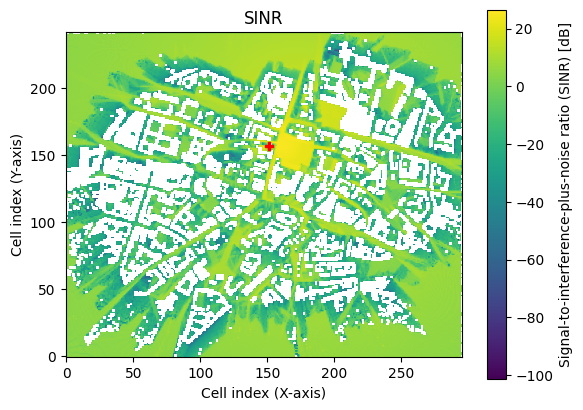

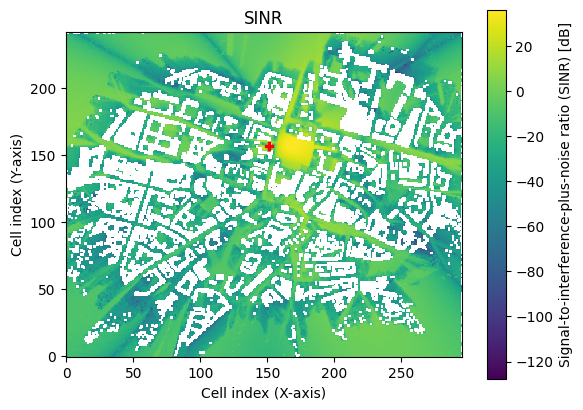

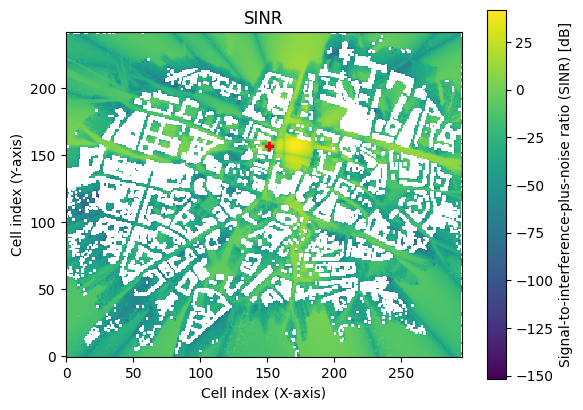

In [17]:
# --- Comparing SINR for Dipole Antenna Configurations ---

# Visualize SINR map for single TX antenna (1x1) with dipole pattern
im4 = cm_maps['cm1_di'].show(metric='sinr')
print('1 TX antenna (dipole): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm1_di'])))

# Visualize SINR map for 16 TX antennas (4x4) with dipole pattern
im5 = cm_maps['cm16_di'].show(metric='sinr')
print('16 TX antennas (dipole): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm16_di'])))

# Visualize SINR map for 64 TX antennas (8x8) with dipole pattern
im6 = cm_maps['cm64_di'].show(metric='sinr')
print('64 TX antennas (dipole): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm64_di'])))

1 TX antenna (tr38901): Max SINR = 31.35915994644165
16 TX antennas (tr38901): Max SINR = 42.38786697387695
64 TX antennas (tr38901): Max SINR = 48.14678192138672


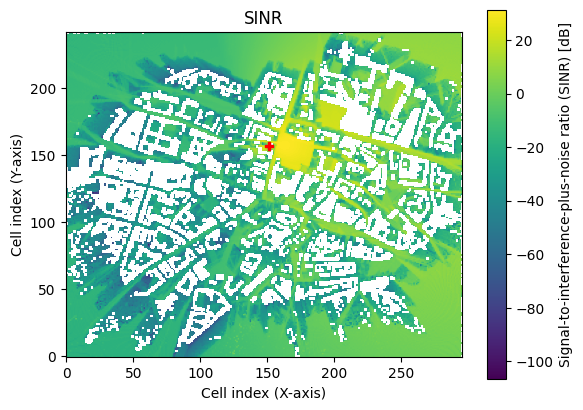

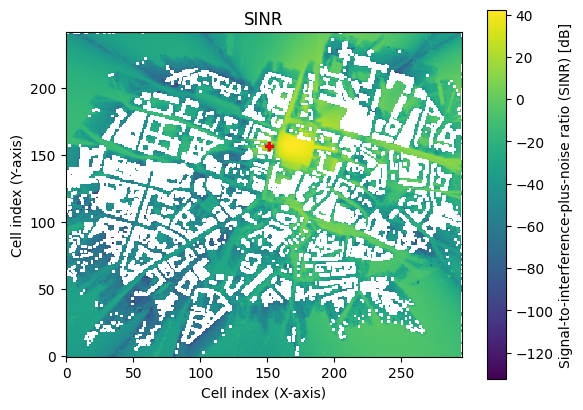

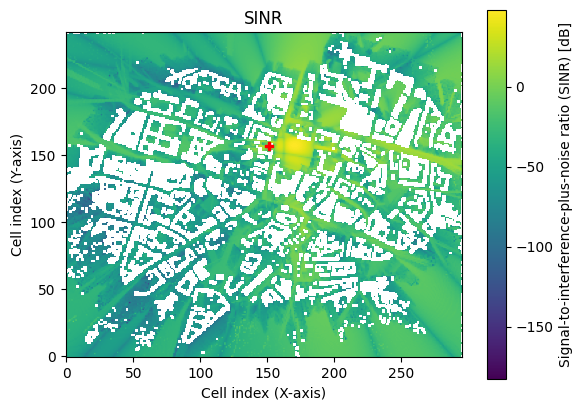

In [18]:
# --- Comparing SINR for TR 38.901 Antenna Configurations ---

# Visualize SINR map for single TX antenna (1x1) with TR 38.901 pattern
im7 = cm_maps['cm1_tr'].show(metric='sinr')
print('1 TX antenna (tr38901): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm1_tr'])))

# Visualize SINR map for 16 TX antennas (4x4) with TR 38.901 pattern
im8 = cm_maps['cm16_tr'].show(metric='sinr')
print('16 TX antennas (tr38901): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm16_tr'])))

# Visualize SINR map for 64 TX antennas (8x8) with TR 38.901 pattern
im9 = cm_maps['cm64_tr'].show(metric='sinr')
print('64 TX antennas (tr38901): Max SINR =', 10 * np.log10(np.max(sinr_maps['cm64_tr'])))


Random look_at points: [[96.80508574875003, 77.14824996510588, 1.120881577200043], [63.48853092806094, 105.37646845338396, 4.108181494059229], [31.654372776222683, 124.3915620039553, -0.02002425516477757], [97.55708919292073, 52.94237383724428, -5.250082518253678], [4.2451898890411925, 112.54114645196152, -8.313284452043355], [69.06842258170693, 117.87617644808921, 3.5040843834546394], [85.70391539968726, 100.17421528008846, 2.98667118371605], [32.38422566965936, 86.84883589514303, -5.814099480257678], [67.98922526377369, 63.30047639302299, 1.2765562433254019], [76.52990819327728, 88.96521938845653, -5.1999736162665045]]
Points for SINR extraction: [(153, 180), (158, 173), (162, 167), (148, 180), (160, 161), (161, 174), (157, 178), (155, 167), (150, 174), (155, 176)]
cm64_iso: ['23.46', '38.44', '30.10', '-2.59', '21.43', '34.59', '31.50', '37.17', '18.84', '33.93']
cm16_iso: ['29.24', '33.24', '32.71', '26.14', '29.91', '33.28', '31.03', '33.97', '29.56', '31.70']
cm1_iso: ['20.30', '

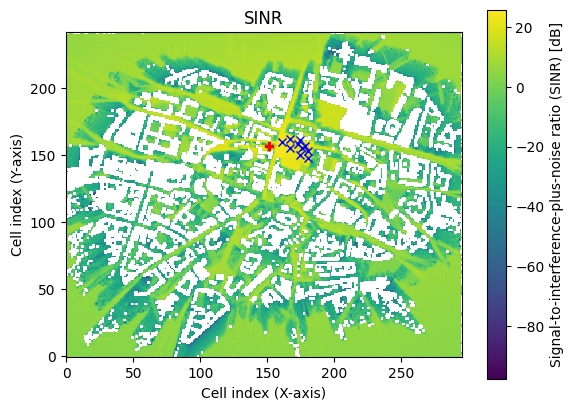

In [23]:
# --- Generate Random Look-At Points in 3D Space ---
def generate_random_look_at_points(base_look_at, num_points=10, 
                                   offset_range_x=(-50, 50), 
                                   offset_range_y=(-50, 50), 
                                   offset_range_z=(-10, 10)):
    """
    Generate random 3D points around a base look-at position for variation in direction.
    """
    random_points = []
    for _ in range(num_points):
        dx = np.random.uniform(*offset_range_x)
        dy = np.random.uniform(*offset_range_y)
        dz = np.random.uniform(*offset_range_z)
        random_point = [base_look_at[0] + dx, base_look_at[1] + dy, base_look_at[2] + dz]
        random_points.append(random_point)
    return random_points

# --- Find Cell Index for Given User Positions ---
def find_cell_index(user_pos, cell_centers, cell_size):
    """
    Given user positions, return the corresponding cell indices and distances to cell centers.
    
    user_pos: shape [1, num_points, 3]
    cell_centers: tensor of shape [H, W, 3]
    cell_size: tuple of (cell_width, cell_height)
    """
    num_users = user_pos.shape[1]
    cell_zero_pos_x = cell_centers[0,0,0]
    cell_zero_pos_y = cell_centers[0,0,1]
    del_x = cell_size[0]
    del_y = cell_size[1]

    cell_index_x = []
    cell_index_y = []
    distance = []
    
    for user in range(num_users):
        user_pos_x = user_pos[0, user, 0]
        user_pos_y = user_pos[0, user, 1]
        
        # Compute index using geometry of uniform grid
        x_index = tf.math.floor(((user_pos_x - cell_zero_pos_x)-del_x/2)/del_x + 1)
        y_index = tf.math.floor(((user_pos_y - cell_zero_pos_y)-del_y/2)/del_y + 1)

        # Append cell index
        cell_index_x.append(int(x_index))
        cell_index_y.append(int(y_index))

        # Compute Euclidean distance to cell center
        cell_x = cell_centers[int(y_index), int(x_index), 0]
        cell_y = cell_centers[int(y_index), int(x_index), 1]
        dd = tf.math.sqrt((cell_x-user_pos_x)**2 + (cell_y-user_pos_y)**2)
        distance.append(dd)

    return cell_index_x, cell_index_y, distance

# --- Extract SINR Values from Coverage Map ---
def extract_sinr_values(sinr_tensor, points):
    """
    Extract SINR values from a SINR tensor given a list of (row, col) indices.
    """
    sinr_np = sinr_tensor.numpy()
    extracted_values = [10 * np.log10(sinr_np[0, row, col]) for row, col in points]
    return extracted_values

# --- Parameters ---
position = [-50, 100, 105]
base_look_at = [position[0] + 100, position[1], 0]

# Generate 10 random look-at points around base
random_points = generate_random_look_at_points(base_look_at, num_points=10)
print("Random look_at points:", random_points)

# Convert points to tensor format
random_points_tf = tf.convert_to_tensor([random_points], dtype=tf.float32)

# Find corresponding cell indices in coverage map
index_x, index_y, distance = find_cell_index(
    random_points_tf, 
    cm_maps['cm1_iso'].cell_centers, 
    cm_maps['cm1_iso'].cell_size
)

# Pack into (row, col) format
points = list(zip(index_y, index_x))
print("Points for SINR extraction:", points)

# --- Extract SINR Values Across All Configurations ---
extracted_sinr_values = {}
for key, sinr_tensor in sinr_maps.items():
    extracted_sinr_values[key] = extract_sinr_values(sinr_tensor, points)

# Print extracted SINR values (in dB) for each configuration
for key, values in extracted_sinr_values.items():
    formatted_values = [f"{value:.2f}" for value in values]
    print(f"{key}: {formatted_values}")

# --- Visualize SINR Map for Reference (cm1_iso) ---
image = cm_maps['cm1_iso'].show(metric='sinr')  # Plot SINR heatmap

# Overlay sampled SINR extraction points
for row, col in points:
    image.axes[0].plot(col, row, marker='x', color='blue', markersize=6, linestyle='', label="SINR Extraction Points")

# Show the final plot
plt.show()


Path gain map keys: ['cm64_iso', 'cm16_iso', 'cm1_iso', 'cm64_tr', 'cm16_tr', 'cm1_tr', 'cm64_di', 'cm16_di', 'cm1_di']
First boolean map preview:
 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Plotting index 0 - cm64_iso


/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22341/339084014.py:7: RuntimeWarning: divide by zero encountered in log10
  mapp = 10. * np.log10(coveragemap_list[0])


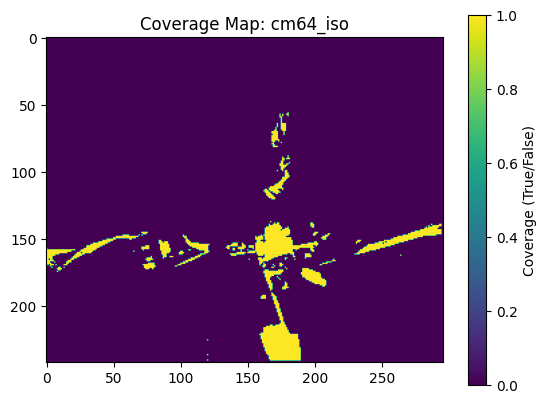

Plotting index 1 - cm16_iso


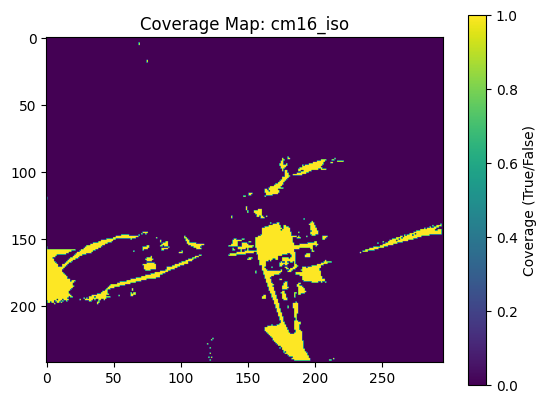

Plotting index 2 - cm1_iso


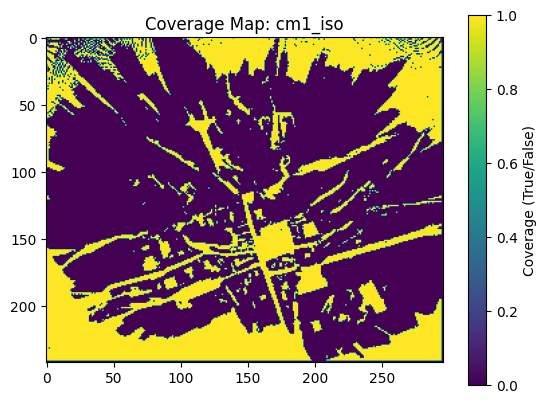

In [24]:
# --- Function to Calculate Boolean Coverage Map Based on Threshold ---
def calculate_cover(coveragemap_list, txpow, threshold, limitarea=True, ar_begin=40, ar_end=200, col_begin=50, col_end=250):
    # Initialize a boolean map (all False)
    map = np.zeros_like(coveragemap_list[0], dtype=bool)

    # Convert path gain to dB and check if received signal strength > threshold
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp + txpow > threshold)  # received power in dBm

    # Merge into final map
    map = np.logical_or(map, mapp)

    # Optionally crop to area of interest
    if limitarea:
        map = map[ar_begin:ar_end, col_begin:col_end]

    return map

# --- Parameters ---
TH = -90  # Threshold in dBm

# Extract keys and path gain tensors from dictionary
path_gain_keys = list(path_gain_maps.keys())
path_gain_list = list(path_gain_maps.values())

# Print keys just to confirm input order
print("Path gain map keys:", path_gain_keys)

# Compute coverage result for each path gain map
result_list = []
for path_gain in path_gain_list:
    result_list.append(calculate_cover(path_gain, TX_PWR, TH, limitarea=False))

# Convert results to a single array for easier slicing/plotting
SISO_result = np.array(result_list)

# Display one example result
print("First boolean map preview:\n", SISO_result[0])

# --- Visualize first 3 coverage maps with titles from config names ---
for i in range(3):
    print(f"Plotting index {i} - {path_gain_keys[i]}")
    plt.figure()
    plt.imshow(SISO_result[i], cmap='viridis')
    plt.colorbar(label='Coverage (True/False)')
    plt.title(f'Coverage Map: {path_gain_keys[i]}')
    plt.show()


Coverage map 3 - cm64_tr


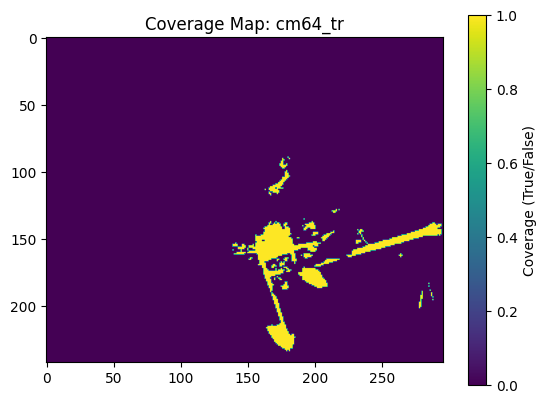

Coverage map 4 - cm16_tr


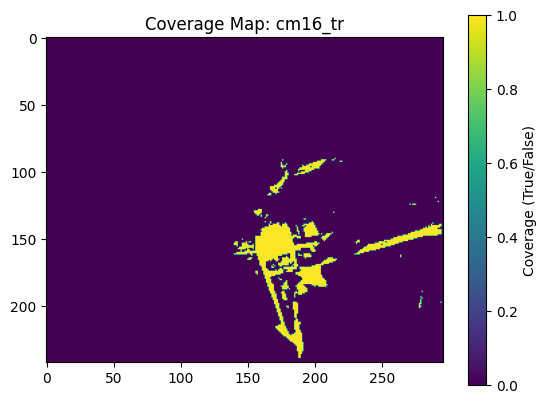

Coverage map 5 - cm1_tr


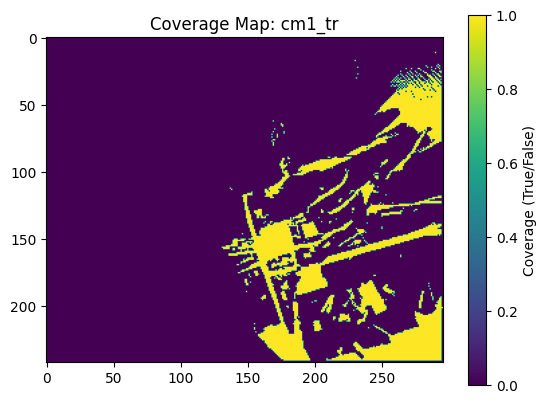

In [25]:
# --- Visualize coverage maps 3 to 5 (inclusive) with antenna type titles ---
for i in range(3, 6):
    print(f"Coverage map {i} - {path_gain_keys[i]}")
    plt.figure()
    plt.imshow(SISO_result[i], cmap='viridis')
    plt.colorbar(label='Coverage (True/False)')
    plt.title(f'Coverage Map: {path_gain_keys[i]}')
    plt.show()



Coverage map 6 - cm64_di


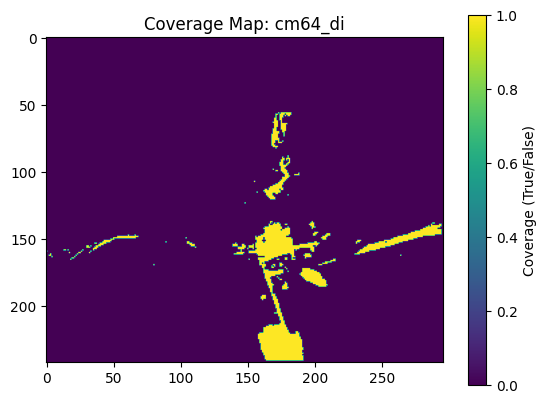

Coverage map 7 - cm16_di


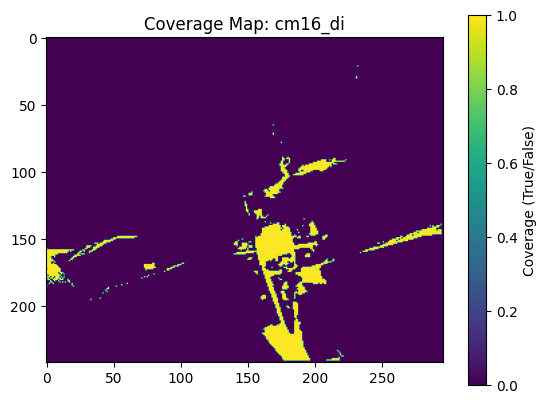

Coverage map 8 - cm1_di


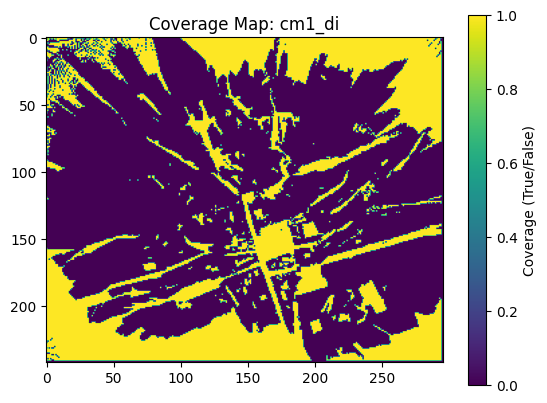

In [26]:
# --- Visualize coverage maps 6 to 8 (inclusive) with antenna type titles ---
for i in range(6, 9):
    print(f"Coverage map {i} - {path_gain_keys[i]}")
    plt.figure()
    plt.imshow(SISO_result[i], cmap='viridis')
    plt.colorbar(label='Coverage (True/False)')
    plt.title(f'Coverage Map: {path_gain_keys[i]}')
    plt.show()
